In [1]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

from random import sample
from math import ceil, sqrt

# Instance Construction

In [2]:
# Create a random planar graph:
graph = nx.convert_node_labels_to_integers(nx.triangular_lattice_graph(3, 3))
edges_to_remove = sample(list(graph.edges()), k=int(0.4 * graph.number_of_edges()))
graph.remove_edges_from(edges_to_remove)

# Read an input graph:
# graph = nx.read_edgelist('instances/planar_1.in', create_using=nx.Graph, nodetype=int)

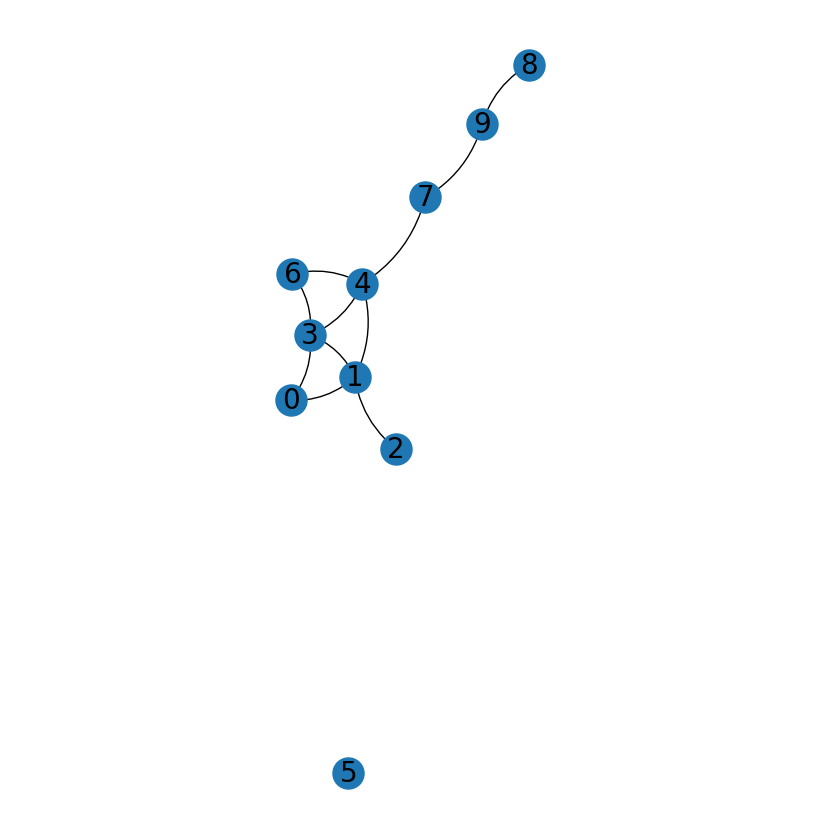

In [3]:
n = len(graph)
V = graph.nodes()
E = graph.edges()

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(graph, with_labels=True, node_size=500, font_size=20, arrows=True, connectionstyle='arc3,rad=0.2')
plt.axis('equal')
plt.show()

# Create the Model

In [4]:
m = gp.Model('grid-drawing')

## Dimensions bounds:
WIDTH, HEIGHT = 10, 10

## Variables:
width = m.addVar(ceil(sqrt(n)) - 1, WIDTH, 0, GRB.INTEGER, 'w')
height = m.addVar(1, HEIGHT, 0, GRB.INTEGER, 'h')
x = m.addVars(V, lb=0, ub=WIDTH, vtype=GRB.INTEGER, name='x')
y = m.addVars(V, lb=0, ub=HEIGHT, vtype=GRB.INTEGER, name='y')
m.update()

m.addConstrs(((x[u] - x[v]) ** 2 + (y[u] - y[v]) ** 2 >= 1
              for u in V for v in V if u < v), name='diff')  # all used grid points are distinct
m.addQConstr((height + 1) * (width + 1) >= n, name='min_num')  # minimum number of grid points
m.addConstrs((x[i] <= width for i in V), name='x_bound')  # all x's must be within the bounding box
m.addConstrs((y[i] <= height for i in V), name='y_bound')  # all y's must be within the bounding box
m.addConstr(width >= height, name='lied_down')  # remove some symmetries by forcing a lied down box
m.update()

Set parameter Username
Set parameter LicenseID to value 2615956
Academic license - for non-commercial use only - expires 2026-01-28


In [5]:
def add_segment_separation_constraints(model, e, f, epsilon=0.001):
    """
    Adds constraints to ensure that segments e and f do not intersect.

    Args:
        model: Gurobi model.
        e: Tuple of indices representing segment e.
        f: Tuple of indices representing segment f.
        epsilon: Small constant for strict separation.

    Returns:
        ha, hb, hc: Hyperplane variables.
    """
    # Continuous variables for hyperplane parameters (a, b, c)
    ha = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"ha[{e + f}]")
    hb = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"hb[{e + f}]")
    hc = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"hc[{e + f}]")

    # Normalization constraint: a_h + b_h = 1
    model.addConstr(ha + hb == 1, name="normalization")

    # Separation constraints for segment e
    for i in e:
        model.addConstr(ha * x[i] + hb * y[i] + hc + epsilon <= 0, name=f"sep_e_{i}")

    # Separation constraints for segment f
    for i in f:
        model.addConstr(ha * x[i] + hb * y[i] + hc - epsilon >= 0, name=f"sep_f_{i}")

    return ha, hb, hc


def add_non_strict_separation_constraints(model, e, f, epsilon=1E-2):
    """
    Adds constraints to ensure that segments e and f do not intersect,
    allowing for a shared endpoint and non-strict separation.

    Args:
        model: Gurobi model.
        e: Tuple of indices representing segment e (e.g., (0, 1) for ab).
        f: Tuple of indices representing segment f (e.g., (1, 2) for bc).

    Returns:
        ha, hb, hc: Hyperplane variables.
    """
    # Continuous variables for hyperplane parameters (a, b, c)
    ha = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"ha[{e + f}]")
    hb = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"hb[{e + f}]")
    hc = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"hc[{e + f}]")

    # Normalization constraint: a_h + b_h = 1
    model.addConstr(ha + hb == 1, name="normalization")

    # Find the shared endpoint (if any)
    shared_point = None
    for i in e:
        if i in f:
            shared_point = i
            break

    if shared_point is not None:
        # Shared endpoint must lie on the hyperplane
        model.addConstr(ha * x[shared_point] + hb * y[shared_point] + hc == 0, name=f"shared_{shared_point}")

        # Other endpoints must lie on opposite sides of the hyperplane
        for i in e:
            if i != shared_point:
                model.addConstr(ha * x[i] + hb * y[i] + hc + epsilon <= 0, name=f"sep_e_{i}")
        for i in f:
            if i != shared_point:
                model.addConstr(ha * x[i] + hb * y[i] + hc - epsilon >= 0, name=f"sep_f_{i}")
    else:
        raise ValueError("Segments must share at least one endpoint for non-strict separation.")

    return ha, hb, hc

In [6]:
for e in E:
    for f in E:
        if e < f:
            if not set(e) & set(f):
                add_segment_separation_constraints(m, e, f)
            else:
                add_non_strict_separation_constraints(m, e, f)
m.update()

# Model Solving

In [7]:
## Objective function:
# m.setObjective(0)
m.setObjective(width + height, GRB.MINIMIZE)

## Solving:
try:
    m.optimize()
    print(f'\nFound a solution with bounding box {int(width.x)}x{int(height.x)}:')
    # Print coordinates for each node:
    for u in V():
        print(f'{u}: ({x[u].x:.2f}, {y[u].x:.2f})')

    # Save the model in a readable format:
    m.write('model.lp')

    # Print variable values after optimization
    print('\nVariables:')
    for var in m.getVars():
        print(f'{var.VarName}: {var.X}')
except gp.GurobiError as e:
    print(f'Error code {e.errno}: {e}')
except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Freedesktop SDK 23.08 (Flatpak runtime)")

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 76 rows, 187 columns and 152 nonzeros
Model fingerprint: 0x5cbbfe88
Model has 244 quadratic constraints
Variable types: 165 continuous, 22 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e-03, 9e+00]
Presolve time: 0.00s
Presolved: 1401 rows, 696 columns, 3180 nonzeros
Presolved model has 1 quadratic constraint(s)
Presolved model has 506 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller bounds for these variables.
         Cons

# Visualize the computed solution

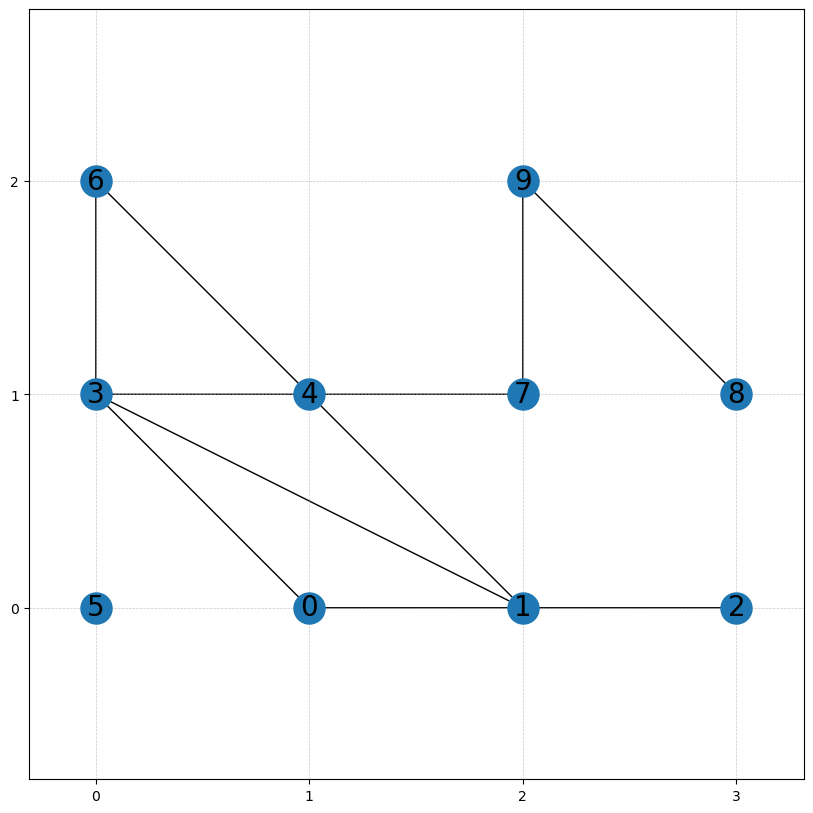

In [8]:
import matplotlib.ticker as ticker


# Extract the coordinates:
pos = {node: (x[node].x, y[node].x) for node in V()}

# Plot the graph with the positions obtained from the model:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(graph, pos=pos, with_labels=True, node_size=500, font_size=20, arrows=True, ax=ax)
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.axis('equal')
plt.show()